In [19]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from collections import Counter

# Configurar pandas para ver texto completo
pd.set_option('display.max_colwidth', 150)

# Cargar el dataset limpio que se guardó antes
try:
    df = pd.read_csv('../data/datos_triaje_limpios.csv')
    print(f"✅ Datos cargados correctamente. Total de filas: {len(df)}")
except FileNotFoundError:
    print("❌ Error: No se encuentra el archivo. Verifica que se ejecuto el Notebook 1.")

# Cargar el modelo de lenguaje en español de Spacy
try:
    nlp = spacy.load("es_core_news_sm")
    print("✅ Modelo de lenguaje español (SpaCy) cargado.")
except OSError:
    print("❌ Error: Modelo de SpaCy no encontrado. Ejecuta en tu terminal: python -m spacy download es_core_news_sm")

✅ Datos cargados correctamente. Total de filas: 6922
✅ Modelo de lenguaje español (SpaCy) cargado.


In [20]:
# Definir las palabras que no se quieren eliminar (negaciones)
negaciones = {'no', 'sin', 'ni', 'nunca', 'jamás', 'tampoco'}

# Definir las palabras que se quiere eliminar (stopwords)
stopwords = nlp.Defaults.stop_words

# Ajustar las stopwords para que las negaciones no se eliminen
for palabra in negaciones:
    nlp.vocab[palabra].is_stop = False

def procesar_texto_medico(texto):
    # 1. Convertir a objeto SpaCy (Tokenización automática)
    doc = nlp(texto)
    
    tokens_limpios = []
    
    for token in doc:
        # Filtros:
        # - Que no sea signo de puntuación (is_punct)
        # - Que no sea una 'stopword' (is_stop)
        # - Que sea letras y no números sueltos (is_alpha)
        if not token.is_punct and not token.is_stop and token.is_alpha:
            # 2. Lematización: Tomar la raíz de la palabra (lemma_) y se pasa a minúsculas
            tokens_limpios.append(token.lemma_.lower())
            
    # Unir las palabras limpias de nuevo en una frase
    return " ".join(tokens_limpios)

# Probemos la función con un ejemplo
ejemplo = "El paciente presenta dolores fuertes en el abdomen y vómitos constantes."
print(f"Original: {ejemplo}")
print(f"Procesado: {procesar_texto_medico(ejemplo)}")

Original: El paciente presenta dolores fuertes en el abdomen y vómitos constantes.
Procesado: paciente presentar dolor fuerte abdomen vómito constante


In [21]:
print("⏳ Procesando todo el dataset (esto puede tardar unos segundos)...")

# Aplicar la función a la columna 'sintomas'
df['sintomas_procesados'] = df['sintomas'].apply(procesar_texto_medico)

print("✅ ¡Procesamiento terminado!")

# Comparar el Antes y el Después
display(df[['sintomas', 'sintomas_procesados']].head(5))

⏳ Procesando todo el dataset (esto puede tardar unos segundos)...


✅ ¡Procesamiento terminado!


,sintomas,sintomas_procesados
0,Se trata de un varón de 27 años de edad que ingresa por politraumatismo después de precipitarse desde 15 metros. Es atendido en el lugar del accid...,varón año edad ingresar politraumatismo precipitar él metro atender lugar accidente glasgow coma scale punto estabilidad hemodinámico tacht diagno...
1,"DIAGNÓSTICO DE INGRESO: , Fractura de cadera izquierda.,QUEJA PRINCIPAL: , Función disminuida, secundaria a lo anterior.,HISTORIAL: , Este agradab...",diagnóstico ingreso fractura cadera izquierdo principal función disminuido secundario agradable caballero año caída nivel suelo casa llevar centro...
2,"DIAGNÓSTICO: Cáncer de nasofaringe T1 N3 M0, estado posterior a la radioterapia con 2 ciclos de dosis altas de cisplatino con radiación, completad...",diagnóstico cáncer nasofaringe posterior radioterapia ciclo dosis alto cisplatino radiación completado junio posterior ciclo administrado terapia ...
3,QUEJA PRINCIPAL: Dolor de espalda severo y somnolencia. La paciente no es un buen historiador y la historia se obtuvo del esposo de la paciente ju...,queja principal dolor espalda severo somnolencia paciente no historiador historia obtener esposo paciente cama antecedente enfermedad actual pacie...
4,"DIAGNÓSTICO PREOPERATORIO: Quiste sebáceo reinfectado recurrente del abdomen. DIAGNÓSTICO POSTOPERATORIO:,1. Absceso secundario a cuerpo extraño ...",diagnóstico preoperatorio quiste sebáceo reinfectado recurrente abdomen diagnóstico absceso secundario cuerpo extraño retenido hernia incisional e...


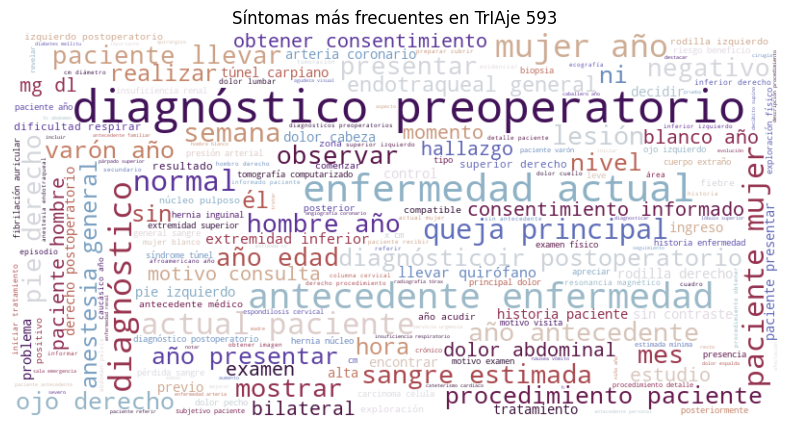

In [22]:
from wordcloud import WordCloud

# Unir todo el texto procesado en un solo bloque gigante
texto_completo = " ".join(df['sintomas_procesados'])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='twilight').generate(texto_completo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Síntomas más frecuentes en TrIAje 593')
plt.show()

In [23]:
# Guardar solo las columnas que se necesitan para entrenar
df_final = df[['sintomas_procesados', 'especialidad']]

# Eliminar filas que hayan quedado vacías después de la limpieza
df_final = df_final[df_final['sintomas_procesados'].str.strip() != '']

df_final.to_csv('../data/datos_nlp_procesados.csv', index=False)
print("✅ Archivo 'datos_nlp_procesados.csv' guardado en /data ready para Machine Learning.")

✅ Archivo 'datos_nlp_procesados.csv' guardado en /data ready para Machine Learning.
